# 『Kickstarter Projects』
## 課題 クラウドファンデイングが成功するか(state)を予測
### 名前 北神眞哉

### 目次  
1. データ概要
1. 前処理
1. モデル生成
1. モデルの評価結果

## 1.データ概要

In [1]:
%matplotlib inline
import codecs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))

from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import GridSearchCV,cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error

from pandas.plotting import scatter_matrix

<Figure size 1440x720 with 0 Axes>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv ('./kickstarter-projects/ks-projects-201801.csv')

In [4]:
display(df.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [6]:
df.corr()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
ID,1.000000,0.001679,0.000466,0.000654,-0.000633,-0.000025,0.001854
goal,0.001679,1.000000,0.007358,0.004012,0.005534,0.005104,0.942692
pledged,0.000466,0.007358,1.000000,0.717079,0.857370,0.952843,0.005024
backers,0.000654,0.004012,0.717079,1.000000,0.697426,0.752539,0.004517
usd pledged,-0.000633,0.005534,0.857370,0.697426,1.000000,0.907743,0.006172
usd_pledged_real,-0.000025,0.005104,0.952843,0.752539,0.907743,1.000000,0.005596
usd_goal_real,0.001854,0.942692,0.005024,0.004517,0.006172,0.005596,1.000000


In [7]:
#_ = scatter_matrix(df)

### データ

 - ID ... 内部ID
 - name ... プロジェクト名　
 - categroy ... カテゴリー   
 - main_category ... 主カテゴリー 
 - currensy ... 通貨の種類  
 - deadlile ... 期日             
 - goal ... 目標金額 
 - launched ... プロジェクト開始日
 - pledged ... 集金額 
 - state ... プロジェクトの現状 
 - backers ... 支援者数 
 - country ... 発案元の国 
 - usd pledged ... USD換算の集金額(KS)
 - usd_pledged_real ...　USD換算の集金額(fixer)
 - usd_goal_real ... USD換算の目標金額 


- 目的変数
　- state   failed or successを当てる
 
- 説明変数
  - カテゴリー 
     - categroy
     - main_category
     - currensy
     - country
  - 数値系 
     - deadline - launched　（期間を日数で出す)
     - usd_goal_real　　　　
  
- 削るもの
  - ID
  - name
  - goal
  - pledged
  - backers
  - usd pledged
  - usd_pledged_real

目的変数　state （failed/success を当てる。）
説明変数　カテゴリー　　　　                                                                                     　　　    メインカテゴリー
     　　 通貨
          国名
          　
          期間（日数で出す)
          USD換算の目標金額

カテゴリー 159


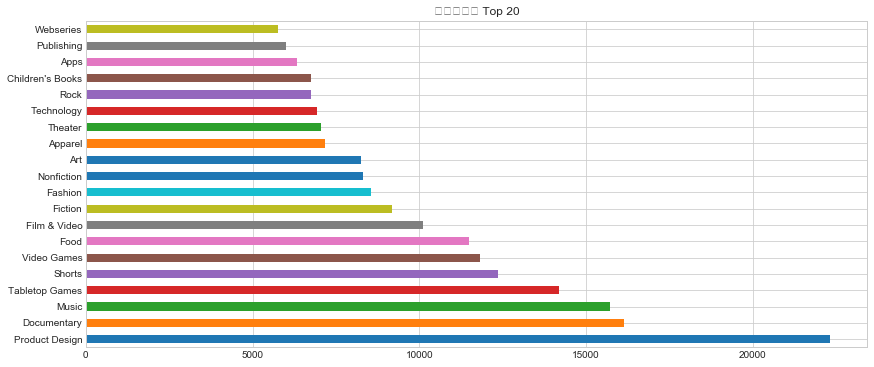

In [8]:
print('カテゴリー', df['category'].nunique())
df['category'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='カテゴリー Top 20')

メインカテゴリー 15


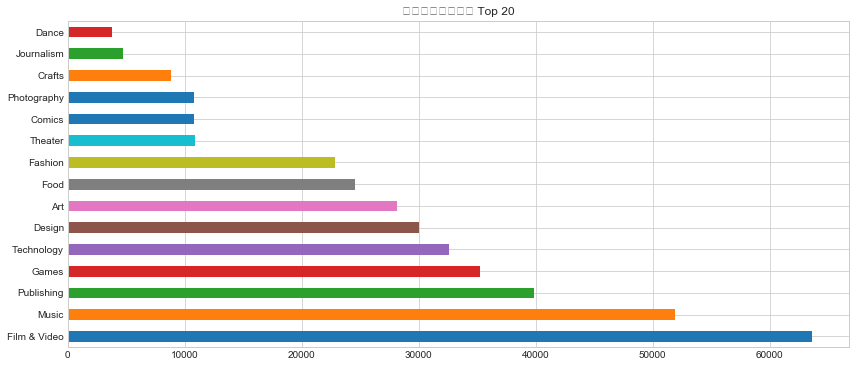

In [9]:
print('メインカテゴリー', df['main_category'].nunique())
df['main_category'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='メインカテゴリー Top 20')

国名 23


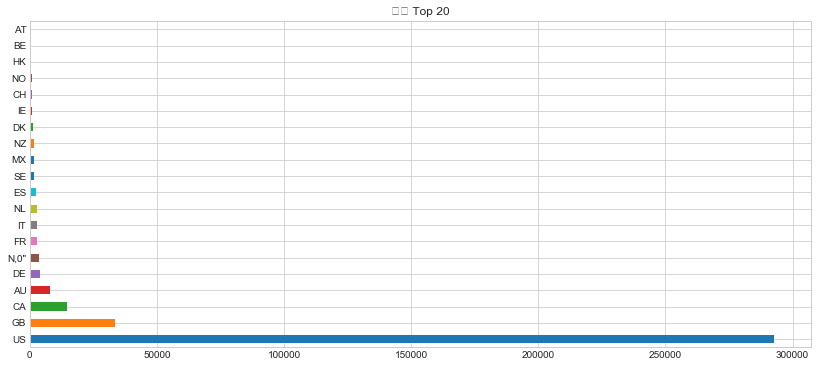

In [10]:
print('国名', df['country'].nunique())
df['country'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='国名 Top 20')        

通貨 14


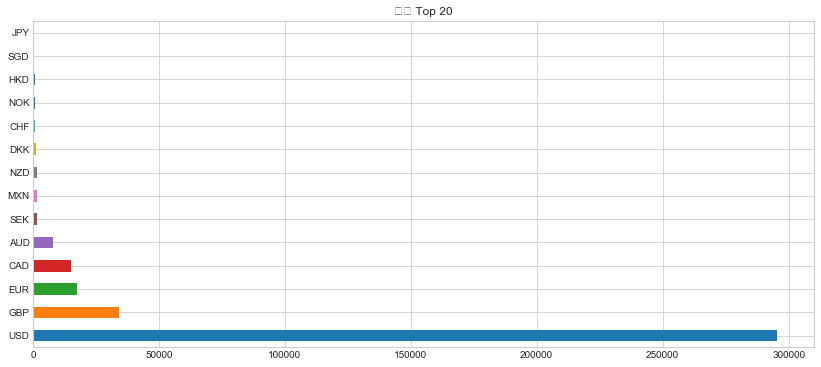

In [11]:
print('通貨', df['currency'].nunique())
df['currency'].value_counts()[:20].plot(kind='barh',
                                       figsize=(14,6),
                                       title='通貨 Top 20')

#### 支援者数

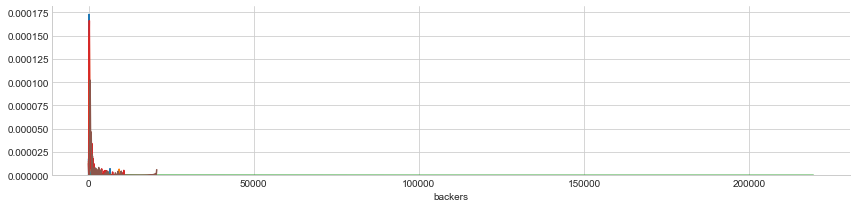

In [12]:
fig = sns.FacetGrid(data=df, hue='state', aspect=4)
fig.map(sns.kdeplot, 'backers', shade=True)

目標金額

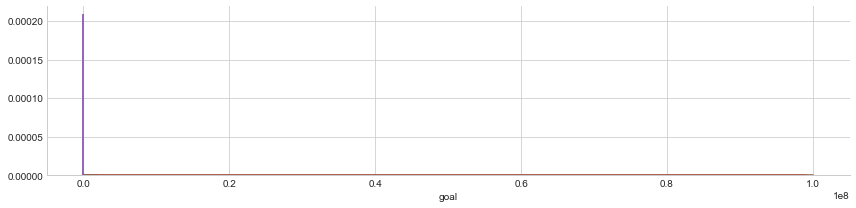

In [13]:
fig = sns.FacetGrid(data=df, hue='state', aspect=4)
fig.map(sns.kdeplot, 'goal', shade=True)

#### USD換算の目標金額

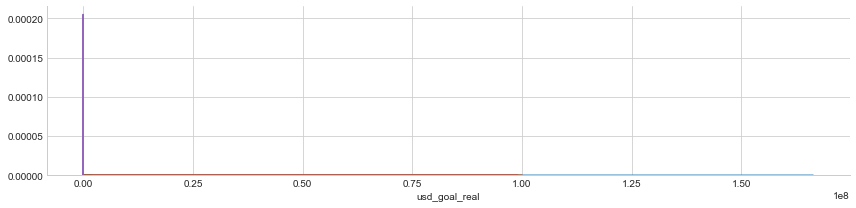

In [14]:
fig = sns.FacetGrid(data=df, hue='state', aspect=4)
fig.map(sns.kdeplot, 'usd_goal_real', shade=True)

## 2.前処理

In [15]:
df = df.drop('ID', axis = 1)
df = df.drop('name', axis= 1)
df = df.drop('goal', axis = 1)
df = df.drop('pledged', axis = 1)
df = df.drop('backers', axis = 1)
df = df.drop('usd pledged', axis = 1)
df = df.drop('usd_pledged_real', axis = 1)

In [16]:
print(df['state'].value_counts(dropna=False))

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64


In [17]:
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')].copy()

In [18]:
df['state'] = df['state'].map({'successful': 1, 'failed': 0})

In [19]:
print(df['state'].value_counts(dropna=False))

0    197719
1    133956
Name: state, dtype: int64


In [20]:
df['launched'] = pd.to_datetime(df['launched'])
df['deadline'] = pd.to_datetime(df['deadline'])

df['duration_days'] = df['deadline'].subtract(df['launched']).astype('timedelta64[D]')

df.drop(['launched', 'deadline'], axis=1,inplace=True)

In [21]:
df.head(5)

,category,main_category,currency,state,country,usd_goal_real,duration_days
0,Poetry,Publishing,GBP,0,GB,1533.95,58.0
1,Narrative Film,Film & Video,USD,0,US,30000.00,59.0
2,Narrative Film,Film & Video,USD,0,US,45000.00,44.0
3,Music,Music,USD,0,US,5000.00,29.0
5,Restaurants,Food,USD,1,US,50000.00,34.0


ワンホット表現を利用する　　　　　

In [22]:
dummy_df = pd.get_dummies(df, columns=['category','main_category','currency','country'],drop_first=True)

In [23]:
dummy_df.head()

,state,usd_goal_real,duration_days,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,0,1533.95,58.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,59.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,44.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,29.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,1,50000.00,34.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3.モデル生成

In [24]:
y = dummy_df['state']

In [25]:
X = dummy_df.drop('state', axis=1)

標準化

In [26]:
#from sklearn.preprocessing import StandardScaler
# Goal、Dulation_daysを標準化する
#norm_X = X
#stdsc = StandardScaler()
#norm_X['usd_goal_real_std'] =  stdsc.fit_transform(norm_X[['usd_goal_real']].values)
#norm_X['duration_days_std'] =  stdsc.fit_transform(norm_X[['duration_days']].values)
#norm_X = norm_X.drop(['usd_goal_real','duration_days'],axis=1)
#X = norm_X

In [27]:
from sklearn.preprocessing import StandardScaler
# Goal、Dulation_daysを標準化する
norm_X = X
stdsc = StandardScaler()
norm_X[['usd_goal_real','duration_days']] =  stdsc.fit_transform(norm_X[['usd_goal_real','duration_days']].values)

In [28]:
norm_X.head()

,usd_goal_real,duration_days,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,-0.036049,1.969990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.010379,2.048648,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.003147,0.868782,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.032924,-0.311084,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.007656,0.082205,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
norm_X.describe()

,usd_goal_real,duration_days,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
count,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,...,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,4.508065e-16,-2.622543e-15,0.002343,0.008261,0.001872,0.000690,0.006672,0.002222,0.018590,0.015940,...,0.000069,0.000172,0.004254,0.000633,0.007269,0.001755,0.003841,0.004550,0.001369,0.788000
std,1.000002e+00,1.000002e+00,0.048344,0.090515,0.043230,0.026267,0.081411,0.047086,0.135074,0.125245,...,0.008327,0.013108,0.065085,0.025155,0.084949,0.041853,0.061858,0.067297,0.036972,0.408725
min,-3.743254e-02,-2.592157e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-3.562901e-02,-3.110835e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-3.292369e-02,-3.110835e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,-2.390597e-02,1.608628e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.499826e+02,4.565695e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

In [31]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(norm_X, y)

acc_log = round(clf.score(norm_X, y) * 100, 2)
print('学習率={:.3f}%'.format(acc_log))

学習率=66.910%


In [32]:
# ラベルを予測
y_pred = clf.predict(norm_X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.906%
適合率（Precision） = 69.625%
再現率（Recall） = 78.910%
F1値（F1-score） = 73.977%


In [33]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = Failed', '正解 = Success'], 
                        columns=['予測 = Failed', '予測 = Success'])
conf_mat

,予測 = Failed,予測 = Success
正解 = Failed,156021,41698
正解 = Success,68068,65888


ホールドアウト法

In [34]:
from sklearn.model_selection import train_test_split
## 9:1にトレーニングとテストデータを分割
norm_X_train, norm_X_test, y_train, y_test = train_test_split(
    norm_X, y, 
    test_size = 0.2,
    random_state=42
)
 
print(norm_X_train.shape, y_train.shape)
print(norm_X_test.shape, y_test.shape)    

(265340, 209) (265340,)
(66335, 209) (66335,)


In [35]:
# SGDの実行

clf_sgd = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-3)
clf_sgd.fit(norm_X_train, y_train)

acc_log = round(clf_sgd.score(norm_X_train, y_train) * 100, 2)
print('学習率={:.3f}%'.format(acc_log))

学習率=66.530%


In [36]:
#clf_sgd = SGDClassifier(loss='log', penalty='l2', fit_intercept=True, random_state=1234)
#clf_sgd.fit(X_train, y_train)

#acc_log = round(clf_sgd.score(X_test, y_test) * 100, 2)
#print('SGD正答率={:.3f}%'.format(acc_log))

In [37]:
# ラベルを予測
y_pred = clf.predict(norm_X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 66.891%
適合率（Precision） = 69.553%
再現率（Recall） = 79.093%
F1値（F1-score） = 74.017%


In [38]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                        index=['正解 = Failed', '正解 = Success'], 
                        columns=['予測 = Failed', '予測 = Success'])
conf_mat

,予測 = Failed,予測 = Success
正解 = Failed,31282,8269
正解 = Success,13694,13090


交差検証法（クロスバリデーション）

In [39]:
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.metrics import mean_absolute_error # 回帰問題における性能評価に関する関数

In [40]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

scoring = ["accuracy","precision_macro","recall_macro","f1_macro"]
scores = cross_validate(clf, norm_X, y, scoring=scoring, cv=5)
for key,value in scores.items():
    print("{}:{:.3f}+/-{:.3f}".format(key, value.mean(), value.std()))

fit_time:4.302+/-0.303
score_time:0.833+/-0.039
test_accuracy:0.665+/-0.003
train_accuracy:0.666+/-0.002
test_precision_macro:0.651+/-0.004
train_precision_macro:0.652+/-0.002
test_recall_macro:0.643+/-0.006
train_recall_macro:0.644+/-0.007
test_f1_macro:0.644+/-0.006
train_f1_macro:0.645+/-0.007


In [41]:
n_split = 5 # グループ数を設定（今回は5分割）

split_num = 1

cross_valid_accuracy_rate = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(norm_X, y):
    norm_X_train, y_train = norm_X.iloc[train_idx], y.iloc[train_idx] #学習用データ
    norm_X_test, y_test = norm_X.iloc[test_idx], y.iloc[test_idx]    #テスト用データ
    
    # 学習用データを使ってSGDモデルを学習
    clf_sgd2 = SGDClassifier(loss='log', penalty='none', max_iter=1000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf_sgd2.fit(norm_X_train, y_train)

    y_pred_test = clf_sgd2.predict(norm_X_test)
    
    print("Fold %s"%split_num)
    accuracy_rate = 100 * accuracy_score(y_test, y_pred_test)
    print('正答率= {:.3f}%'.format(accuracy_rate))
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test)
    print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
    print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
    print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
    
    cross_valid_accuracy_rate += accuracy_rate
    cross_valid_precision += (100 * precision[0])
    cross_valid_recall += (100 * recall[0])
    cross_valid_f1_score += (100 * f1_score[0])
    
    split_num += 1
    
final_accuracy_rate = cross_valid_accuracy_rate / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split

print("Cross Validation")
print("CV 正答率（Accuracy)= %s"%round(final_accuracy_rate, 3))
print("CV 適合率（Precision） = %s"%round(final_precision, 3))
print("CV 再現率（Recall） = %s"%round(final_recall, 3))
print("CV F1値（F1-score） = %s"%round(final_f1_score, 3))    


Fold 1
正答率= 66.582%
適合率（Precision） = 69.998%
再現率（Recall） = 76.323%
F1値（F1-score） = 73.024%
Fold 2
正答率= 66.455%
適合率（Precision） = 71.181%
再現率（Recall） = 73.334%
F1値（F1-score） = 72.241%
Fold 3
正答率= 66.116%
適合率（Precision） = 71.129%
再現率（Recall） = 72.970%
F1値（F1-score） = 72.038%
Fold 4
正答率= 66.291%
適合率（Precision） = 70.980%
再現率（Recall） = 73.502%
F1値（F1-score） = 72.219%
Fold 5
正答率= 66.433%
適合率（Precision） = 70.945%
再現率（Recall） = 74.377%
F1値（F1-score） = 72.620%
Cross Validation
CV 正答率（Accuracy)= 66.375
CV 適合率（Precision） = 70.846
CV 再現率（Recall） = 74.101
CV F1値（F1-score） = 72.428


SVM
線形SVM

In [42]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=1234)

C = 5
clf_svm = LinearSVC(loss='hinge', C=C, class_weight='balanced', random_state=0)
clf_svm.fit(norm_X_train, y_train)

print("学習率= {:.3f}%".format(100 * clf.score(norm_X_train, y_train)))

y_pred = clf.predict(norm_X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))
#acc_log = round(clf_svm.score(norm_X_test, y_test) * 100, 2)
#print('線形SVM正答率 ={:.3f}%'.format(acc_log))

学習率= 66.911%
正答率（Accuracy） = 66.885%
適合率（Precision） = 69.847%
再現率（Recall） = 78.667%
F1値（F1-score） = 73.995%


In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

決定木

In [44]:
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=1234)

clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=1234)
clf = clf.fit(norm_X_train, y_train)

#学習データの学習度合いを表示
print("学習率= {:.3f}%".format(100 * clf.score(norm_X_train, y_train)))

y_pred = clf.predict(norm_X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

学習率= 84.935%
正答率（Accuracy） = 63.770%
適合率（Precision） = 67.907%
再現率（Recall） = 74.907%
F1値（F1-score） = 71.236%


ランダムフォレスト

In [45]:
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=1234)

clf = RandomForestClassifier(n_estimators=10, max_depth=None, criterion="gini",
                            min_samples_leaf=8, min_samples_split=10, random_state=1234)


clf.fit(norm_X_train, y_train)

#学習データの学習度合いを表示
print("学習率= {:.3f}".format(100 * clf.score(norm_X_train, y_train)))

y_pred = clf.predict(norm_X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

学習率= 70.135
正答率（Accuracy） = 67.871%
適合率（Precision） = 70.249%
再現率（Recall） = 80.404%
F1値（F1-score） = 74.984%


アダブースト

In [46]:
#アダブースト（AdaBoost）
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=1234)

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=None,min_samples_leaf=1,min_samples_split=2, random_state=1234,
                        criterion="entropy"),n_estimators=10, random_state=1234)
clf.fit(norm_X_train, y_train)
print("学習率= {:.3f}%".format(100 * clf.score(norm_X_train, y_train)))

y_pred = clf.predict(norm_X_test)

# 正答率を計算
accuracy =  accuracy_score(y_test, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

学習率= 84.935%
正答率（Accuracy） = 63.727%
適合率（Precision） = 67.924%
再現率（Recall） = 74.718%
F1値（F1-score） = 71.159%


SVM(ガウシアンカーネル利用)

In [47]:
#from sklearn.svm import SVC

#C = 5
#kernel = 'rbf'
#gamma = 1
#clf_svm = SVC(C=C, kernel=kernel, gamma=gamma)

In [48]:
#clf_svm.fit(norm_X_train, y_train)
#acc_log = round(clf_svm.score(norm_X_test, y_test) * 100, 2)
#print('ロジスティック回帰正答率 ={:.3f}%'.format(acc_log))

パラメータ最適化(グリッドサーチ)

In [49]:
#tuned_parameters = [
    #{'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma':[0.001, 0.0001]}, 
    #{'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree':[2, 3, 4], 'gamma':[0.001, 0.0001]},
   # {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma':[0.001, 0.0001]}, 
#]

In [50]:
tuned_parameters = [
    {'C': [1, 10], 'kernel': ['rbf'], 'gamma':[0.001, 0.0001]}, 
    {'C': [1, 10], 'kernel': ['poly'], 'degree':[2, 3], 'gamma':[0.001, 0.0001]},
    {'C': [1, 10], 'kernel': ['sigmoid'], 'gamma':[0.001, 0.0001]}, 
]

In [51]:
score = 'f1'
clf = GridSearchCV(SVC(), tuned_parameters, cv=3, n_jobs=-1, scoring='%s_weighted' % score )

In [1]:
clf.fit(norm_X_train, y_train)

NameError: name 'clf' is not defined

In [ ]:
clf.best_params_

In [ ]:
acc_log = round(clf.score(norm_X_test, y_test) * 100, 2)
rint('ロジスティック回帰正答率(最適化) = {:, 3f}%'.format(acc_log))　